In [30]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import os
from scipy.stats import sem, zscore

from fcutils.plot.elements import plot_mean_and_error

sys.path.append("./")

fld = Path(os.getcwd()).parent
sys.path.append(str(fld))

from electrophysiology.utils import load_rec_data, get_locomotion_onset_times

cache = Path("/Users/federicoclaudi/Desktop/APA")
tracking_files = cache.glob("*.parquet")
recordings = [f.stem for f in tracking_files]
len(recordings)



18

### Load all units

In [35]:
DeltaT = 2000 # time before/after frame
BaselineDuration = 2000 # number of samples going into baseline evaluation


units_traces = {}

for i, rec in enumerate(recordings):
    print(f"Doing {i+1} of {len(recordings)}")
    tracking, units = load_rec_data(cache, rec)
    units_names = units.columns

    if len(units.columns) == 0:
        continue

    right_fl_onsets = get_locomotion_onset_times(tracking, "right_fl", cutoff=1500)
    left_fl_onsets = get_locomotion_onset_times(tracking, "left_fl", cutoff=1500)
    if len(right_fl_onsets) == 0 or len(left_fl_onsets) == 0:
        continue

    for i, name in enumerate(units_names):
        alltraces = []
        for paw, timepoints, color in zip(("fr", "fl"), (right_fl_onsets, left_fl_onsets), "rg"):
                traces = []
                for frame in timepoints:
                    trace = units[name].values[frame-DeltaT:frame+DeltaT]


                    if len(trace) < 4000:
                        continue
                    traces.append(trace)
                    

                alltraces.extend(traces)
        units_traces[rec+"_"+name] = np.vstack(alltraces)[:, 1000:3000]


Doing 1 of 18
Found 2694 movement candidates
Found 2694 movement candidates
Doing 2 of 18
Found 1143 movement candidates
Found 1143 movement candidates
Doing 3 of 18
Found 2826 movement candidates
Found 2826 movement candidates
Doing 4 of 18
Found 1847 movement candidates
Found 1847 movement candidates
Doing 5 of 18
Found 1885 movement candidates
Found 1885 movement candidates
Doing 6 of 18
Doing 7 of 18
Doing 8 of 18
Found 3662 movement candidates
Found 3662 movement candidates
Doing 9 of 18
Doing 10 of 18
Doing 11 of 18
Found 2374 movement candidates
Found 2374 movement candidates
Doing 12 of 18
Found 753 movement candidates
Found 753 movement candidates
Doing 13 of 18
Found 3432 movement candidates
Found 3432 movement candidates
Doing 14 of 18
Found 1260 movement candidates
Found 1260 movement candidates
Doing 15 of 18
Found 1706 movement candidates
Found 1706 movement candidates
Doing 16 of 18
Found 1273 movement candidates
Found 1273 movement candidates
Doing 17 of 18
Found 2814 m

## PSTH analysis

Based on this paper: https://elifesciences.org/articles/70129#s4
First, get a matrix Z of N x T (num units by n time samples) of zscored PSTHs. 
Then use PCA to estimate the number of components needed to explain the variance
Then use clustering to get the corresponding number of clusters.

Once we have clusters:
 - visualize clusters responses
 - count num of units in each cluster


Start by collecting all PSTHs in a matrix and creating a heatmap.


Z: (304, 2000)


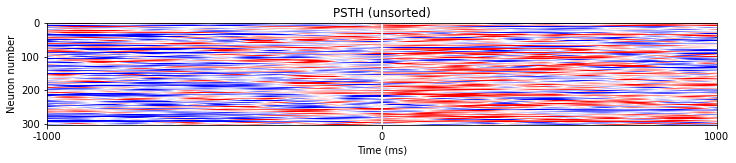

In [45]:
Z = np.vstack(
    [zscore(np.mean(x, 0)) for x in units_traces.values()]
)
print(f"Z: {Z.shape}")


f, ax = plt.subplots(figsize=(12, 10))
ax.imshow(Z, cmap="bwr", clim=[-1, 1])
ax.axvline(1000, lw=2, color="white")
_ = ax.set(xlabel="Time (ms)", xticks=[0, 1000, 2000], xticklabels=[-1000, 0, 1000], ylabel="Neuron number", title="PSTH (unsorted)")


### plot

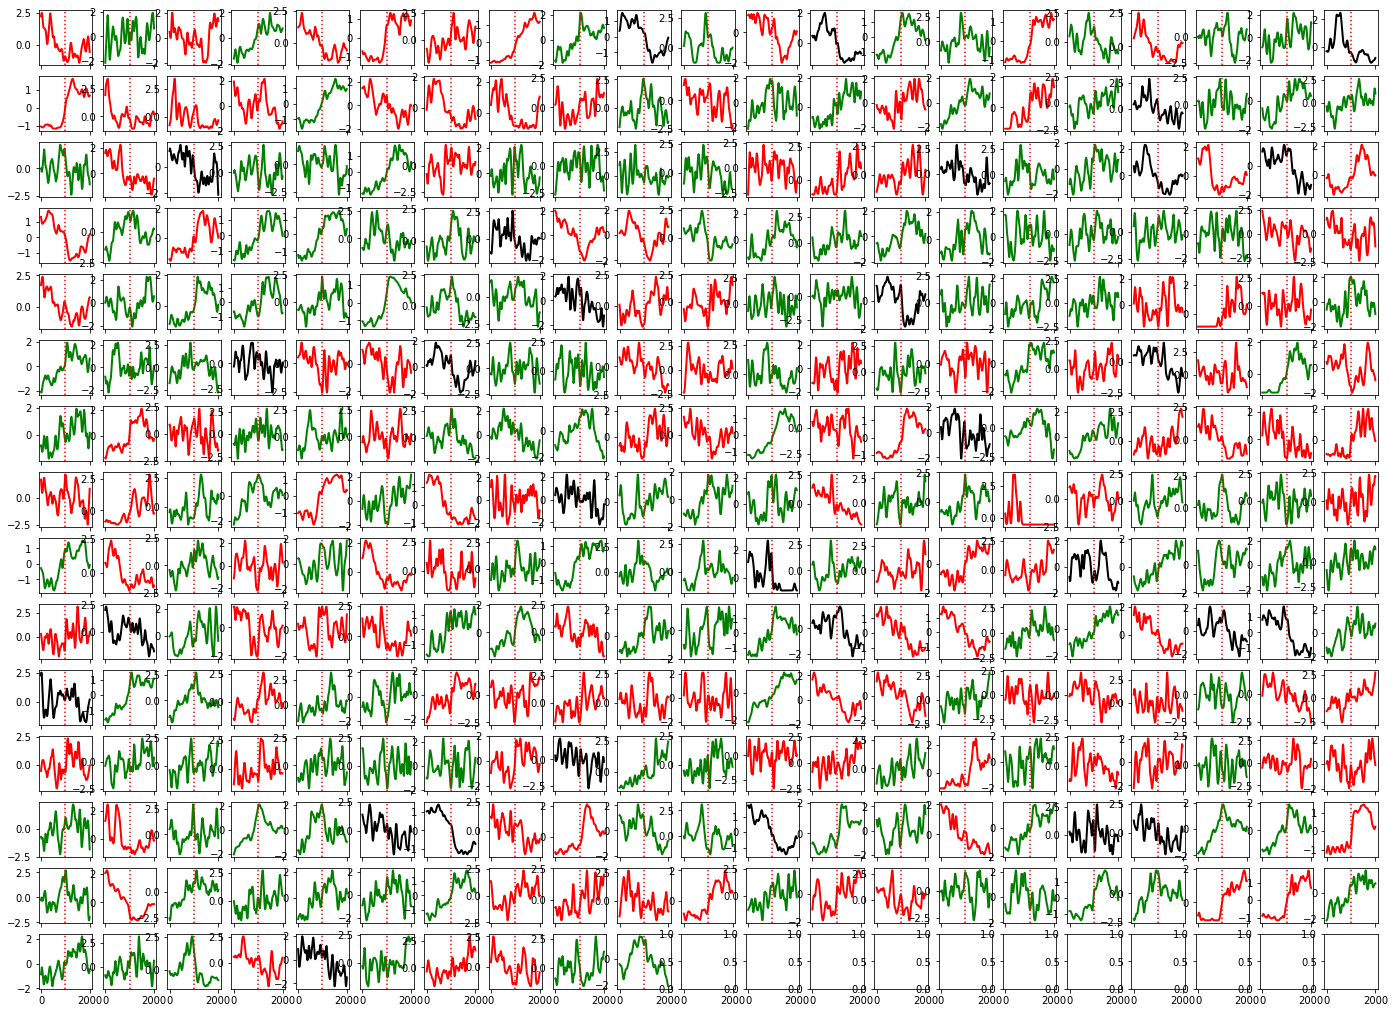

In [36]:
from fcutils.plot.figure import calc_nrows_ncols

nrows, ncols = calc_nrows_ncols(len(units_traces), aspect=(24, 18))
f, axes = plt.subplots(nrows, ncols, figsize=(24, 18), sharex=True, sharey=False)
axes = axes.flatten()

for ax, (name, data) in zip(axes, units_traces.items()):
    mu, sigma = zscore(np.mean(data, 0)), sem(data, 0)

    pre = np.mean(mu[:500])
    post = np.mean(mu[500:1000])

    if pre > post*1.5:
        color="red"
    elif pre < post*0.5:
        color="green"
    else:
        color="black"
    # plot_mean_and_error(mu, sigma, ax, color=color)
    ax.plot(mu, lw=2, color=color)
    ax.axvline(1000, color="red", ls=":")
    